# Stock Market Prediction: Vanilla RNN Analysis by Volatility/Liquidity Buckets

This notebook trains a Vanilla RNN (non-LSTM) on specific stocks.
It evaluates performance across four distinct market quadrants:
- **High Volatility / High Liquidity**
- **High Volatility / Low Liquidity**
- **Low Volatility / High Liquidity**
- **Low Volatility / Low Liquidity**

We track not just the MSE loss, but also Directional Accuracy, and visualize the actual vs. predicted returns.

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import utils
import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Load Data & Define Buckets

In [4]:
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shannanl/sp500-dataset",
  "sp500_data.csv",
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

# Define the specific stocks to analyze
stock_buckets = {
    "High Vol / High Liq": ['KEY', 'VIAC', 'CCL', 'AAPL', 'GILD'],
    "High Vol / Low Liq": ['RL', 'CMG', 'GNRC', 'KSU', 'ODFL'],
    "Low Vol / High Liq": ['JNJ', 'PEP', 'PG', 'KO', 'NEE'],
    "Low Vol / Low Liq": ['WEC', 'AEE', 'DTE', 'VRSK', 'MKC']
}

print("Data loaded and buckets defined.")

100%|██████████| 70.1M/70.1M [00:00<00:00, 123MB/s]

Extracting zip of sp500_data.csv...


Data loaded and buckets defined.


## 2. Model Definition (Vanilla RNN)

In [5]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Standard RNN (batch_first=True)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) # Last time step
        return out

## 3. Processing & Training Pipeline
This function handles everything for a single stock: data loading, feature engineering, training, and metric calculation.

In [6]:
def create_sequences(data_df, seq_length, target_col):
    feature_cols = [c for c in data_df.columns if c not in ['timestep', target_col]]
    data_array = data_df[feature_cols].values
    target_array = data_df[target_col].values

    sequences = []
    targets = []
    for i in range(len(data_array) - seq_length):
        sequences.append(data_array[i:i+seq_length])
        targets.append(target_array[i+seq_length])
    return np.array(sequences), np.array(targets)

def train_and_evaluate_stock(ticker, df_all, epochs=50, hidden_size=64):
    # 1. Load Company Data
    try:
        df_stock = utils.load_comp_data(df_all, ticker)

        if df_stock.shape[1] > 7:
            keep_cols = [c for c in df_stock.columns if c == 'timestep' or c.startswith(f"{ticker}_")]
            df_stock = df_stock[keep_cols]

    except Exception as e:
        print(f"[{ticker}] Error loading data: {e}")
        return None

    df_features = utils.compute_features(df_stock, w=20)
    if isinstance(df_features, str):
        print(f"[{ticker}] Feature error: {df_features}")
        return None

    df_features.dropna(inplace=True)
    if len(df_features) < 100:
        print(f"[{ticker}] Insufficient data")
        return None

    # Prepare Tensors
    SEQ_LENGTH = 60
    X, y = create_sequences(df_features, SEQ_LENGTH, "log_next_day_max_return")

    X_tensor = torch.FloatTensor(X).to(device)
    y_tensor = torch.FloatTensor(y).view(-1, 1).to(device)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
    y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

    # Train Model
    model = VanillaRNN(X_train.shape[2], hidden_size, 1, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    model.train()

    train_losses = []

    for _ in range(epochs):
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Evaluate & Store Results
    model.eval()
    with torch.no_grad():
        preds = model(X_test).cpu().numpy().flatten()
        actuals = y_test.cpu().numpy().flatten()

    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)

    correct_dir = np.sign(preds) == np.sign(actuals)
    dir_acc = np.mean(correct_dir) * 100

    return {
        "mse": mse,
        "mae": mae,
        "dir_acc": dir_acc,
        "predictions": preds,
        "actuals": actuals,
        "train_losses": train_losses
    }

## 4. Main Execution Loop
We iterate through all 20 stocks and store the full results.

In [9]:

full_results = {}
summary_data = []

for bucket, tickers in stock_buckets.items():
    print(f"\n--- Processing Bucket: {bucket} ---")
    full_results[bucket] = {}

    for ticker in tickers:
        print(f"Training {ticker}...")
        try:
            res = train_and_evaluate_stock(ticker, df)
        except Exception as e:
            print(f'Error training {ticker}:', e)
            continue

        if res:
            # Store for detailed plotting later
            full_results[bucket][ticker] = res

            # Store for aggregate summary
            summary_data.append({
                "Bucket": bucket,
                "Ticker": ticker,
                "MSE": res['mse'],
                "MAE": res['mae'],
                "Directional_Accuracy": res['dir_acc'],
            })

summary_df = pd.DataFrame(summary_data)


--- Processing Bucket: High Vol / High Liq ---
Training KEY...
Training VIAC...
Training CCL...
Training AAPL...
Training GILD...

--- Processing Bucket: High Vol / Low Liq ---
Training RL...
Training CMG...
Training GNRC...
Training KSU...
Training ODFL...

--- Processing Bucket: Low Vol / High Liq ---
Training JNJ...
Training PEP...
Training PG...
Training KO...
Training NEE...

--- Processing Bucket: Low Vol / Low Liq ---
Training WEC...
Training AEE...
Training DTE...
Training VRSK...
Training MKC...


## 5. Aggregated Performance Visualization
Comparing performance metrics across all stocks and buckets.

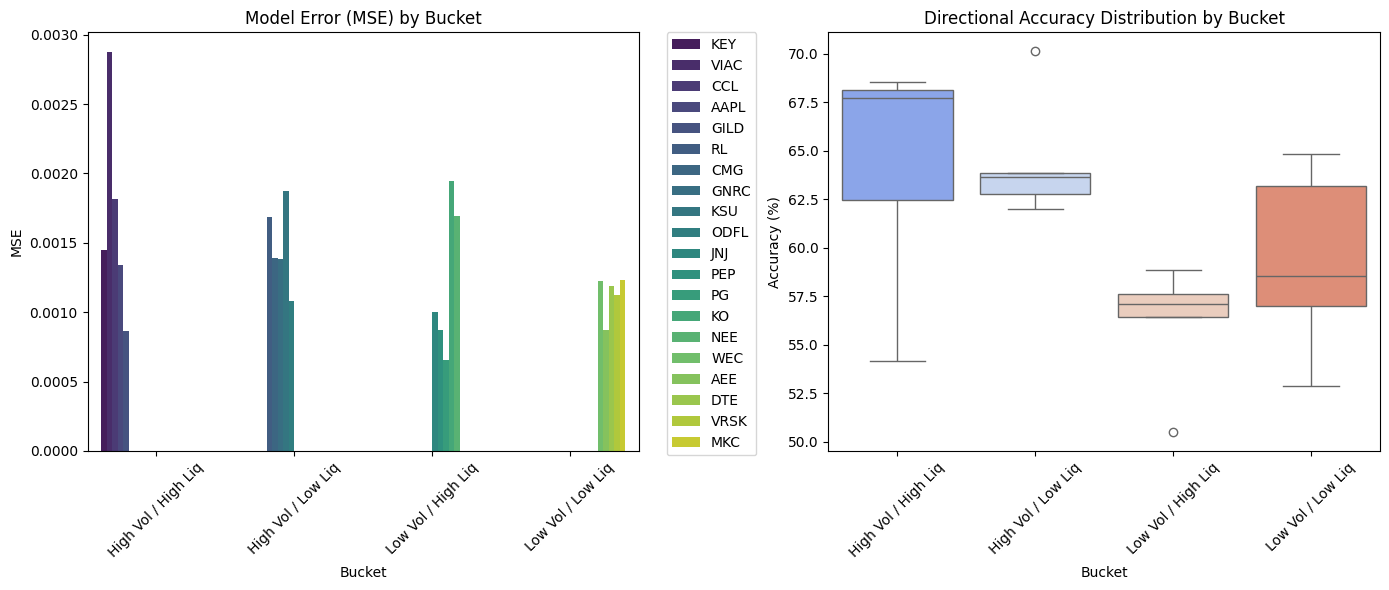

Average Performance by Bucket:
                          MAE  Directional_Accuracy
Bucket                                             
High Vol / High Liq  0.029891             64.205928
High Vol / Low Liq   0.029011             64.463695
Low Vol / High Liq   0.026023             56.096207
Low Vol / Low Liq    0.025800             59.283915


In [10]:
plt.figure(figsize=(14, 6))

# Plot 1: MSE by Stock/Bucket
plt.subplot(1, 2, 1)
sns.barplot(data=summary_df, x="Bucket", y="MSE", hue="Ticker", palette="viridis")
plt.title("Model Error (MSE) by Bucket")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Plot 2: Directional Accuracy
plt.subplot(1, 2, 2)
sns.boxplot(data=summary_df, x="Bucket", y="Directional_Accuracy", palette="coolwarm")
plt.title("Directional Accuracy Distribution by Bucket")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Average Performance by Bucket:")
print(summary_df.groupby("Bucket")[["MAE", "Directional_Accuracy"]].mean())

## 6. Detailed Stock Visualizations
Here we plot the Time Series, Scatter, and Residuals for one representative stock from each bucket to visualize the model's behavior.

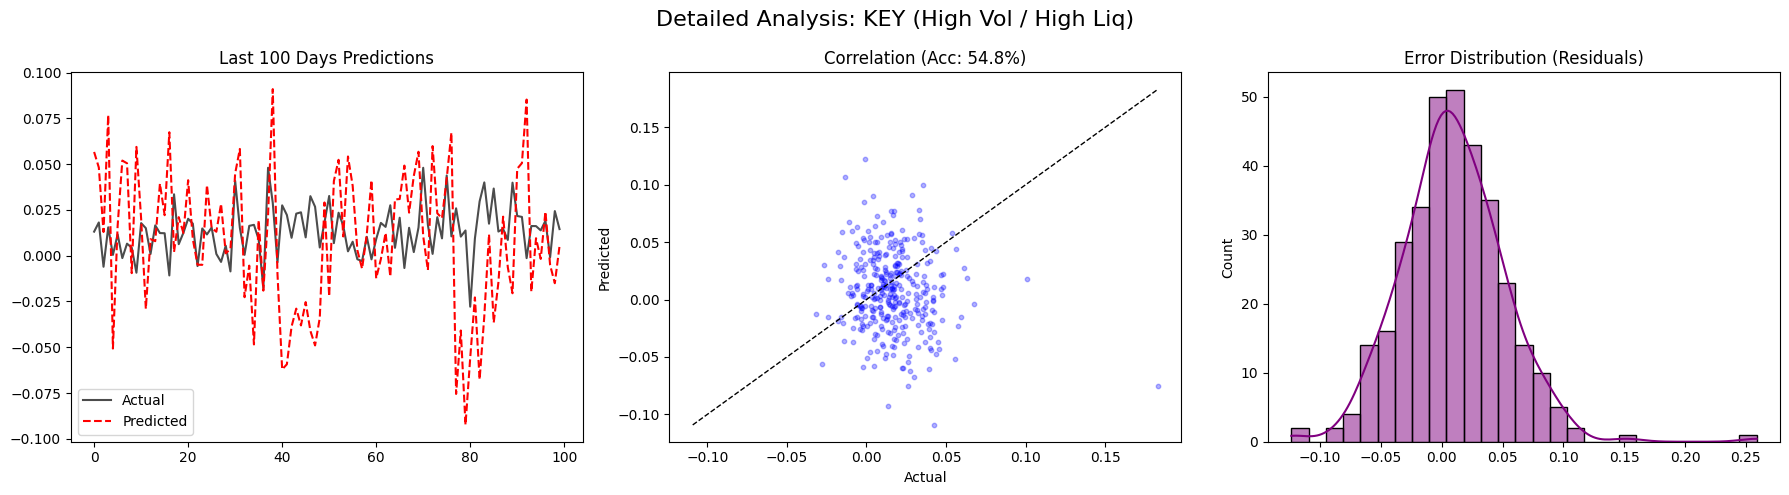

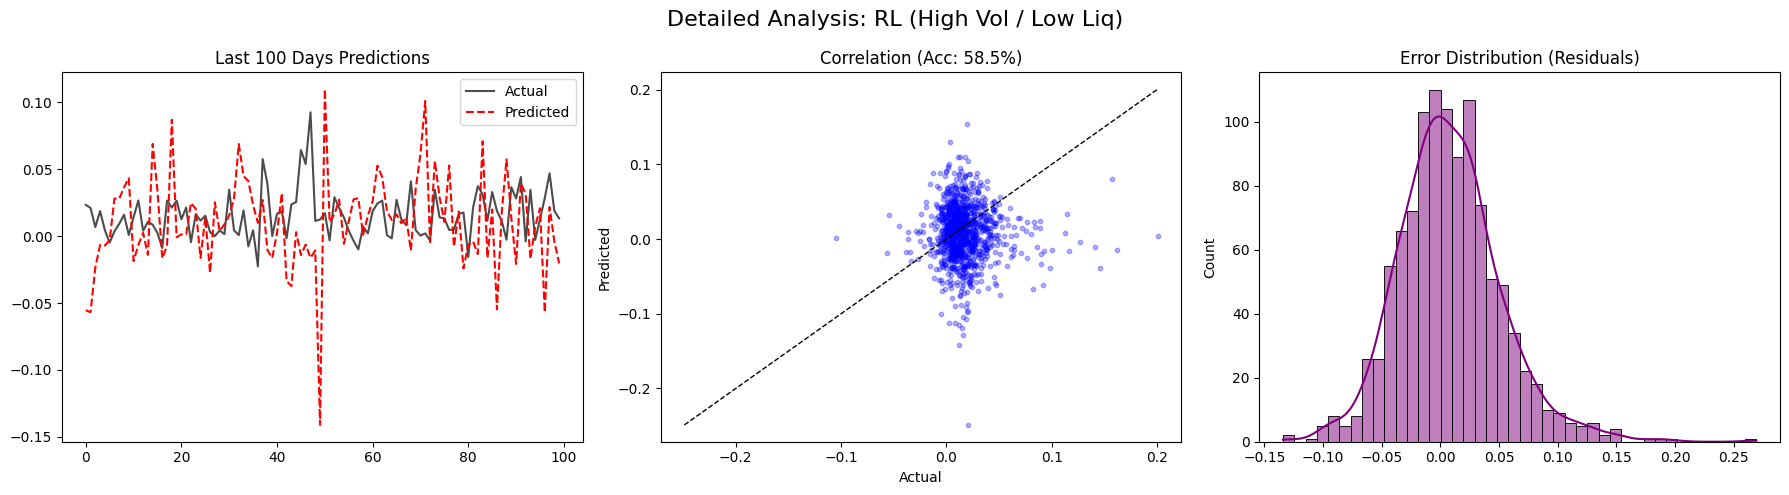

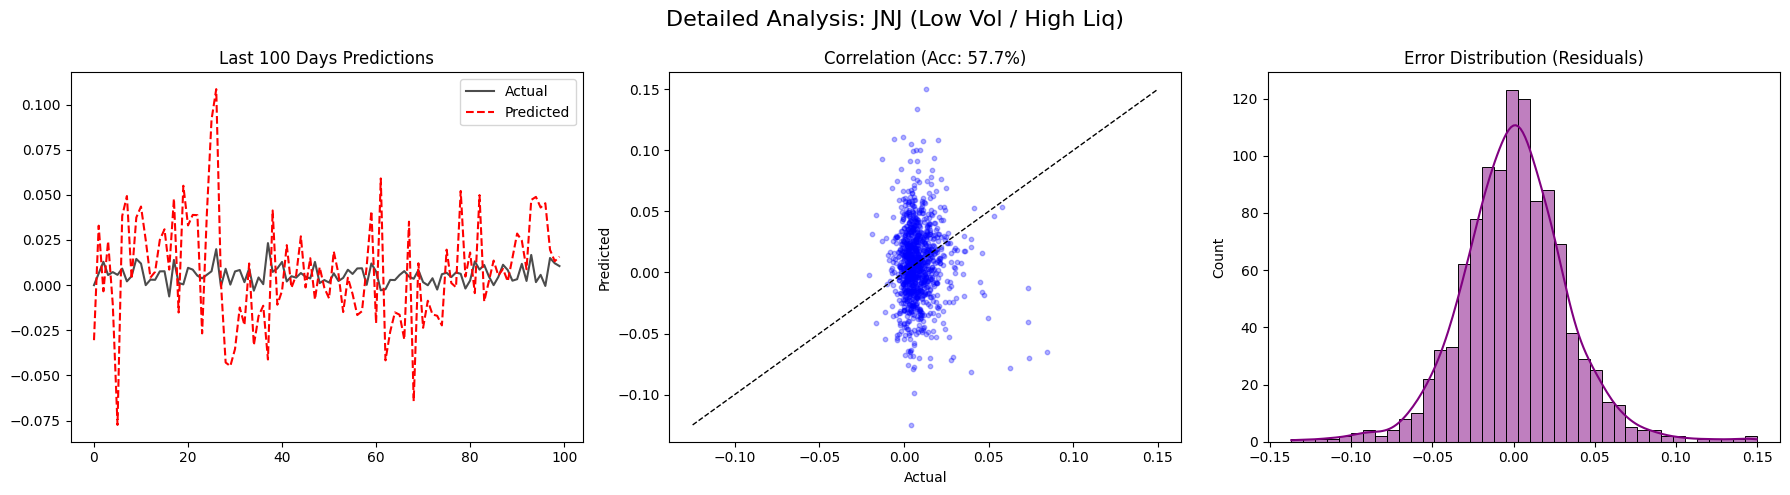

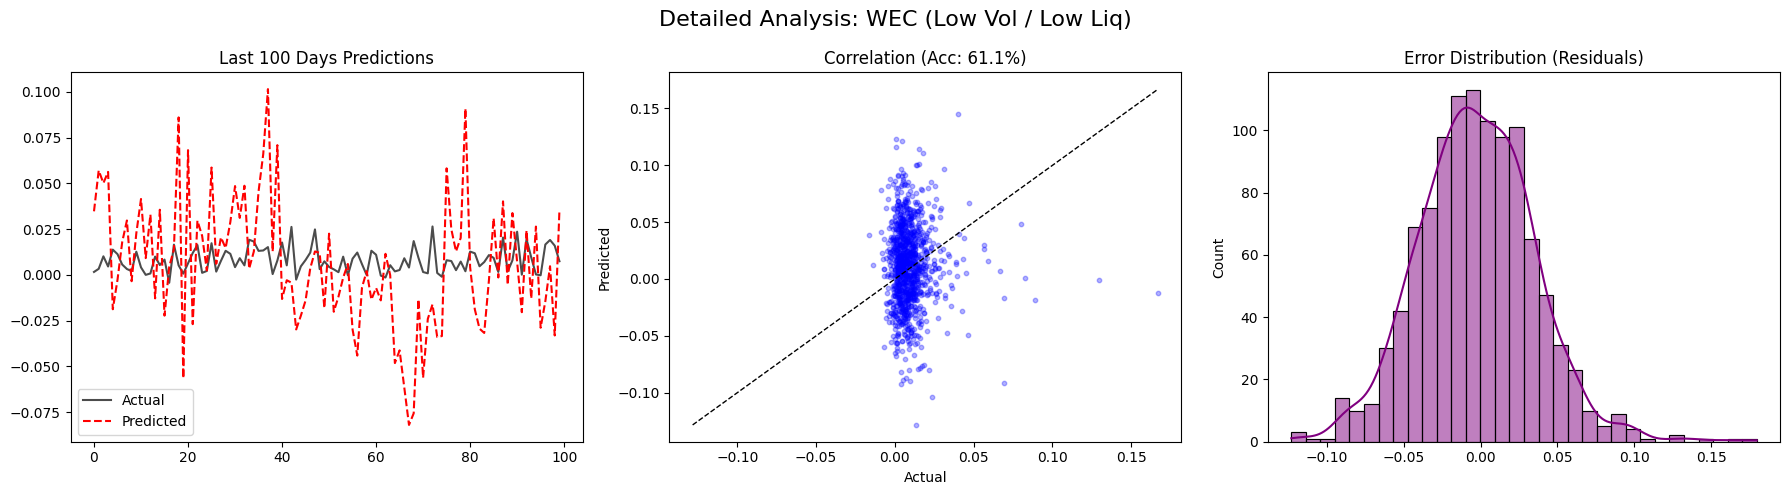

In [ ]:
for bucket in stock_buckets.keys():
    if bucket not in full_results or not full_results[bucket]:
        continue

    # Pick the first successful stock in the bucket to visualize
    ticker = list(full_results[bucket].keys())[0]
    data = full_results[bucket][ticker]

    preds = data['predictions']
    actuals = data['actuals']

    # Create a 3-panel plot for this stock
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Detailed Analysis: {ticker} ({bucket})", fontsize=16)

    # Panel 1: Time Series (Last 100 days)
    axes[0].plot(actuals[-100:], label='Actual', color='black', alpha=0.7)
    axes[0].plot(preds[-100:], label='Predicted', color='red', linestyle='--')
    axes[0].set_title("Last 100 Days Predictions")
    axes[0].legend()

    # Panel 2: Scatter
    axes[1].scatter(actuals, preds, alpha=0.3, color='blue', s=10)
    min_v, max_v = min(actuals.min(), preds.min()), max(actuals.max(), preds.max())
    axes[1].plot([min_v, max_v], [min_v, max_v], 'k--', lw=1)
    axes[1].set_title(f"Correlation (Acc: {data['dir_acc']:.1f}%)")
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")

    # Panel 3: Residuals
    sns.histplot(actuals - preds, kde=True, ax=axes[2], color='purple')
    axes[2].set_title("Error Distribution (Residuals)")

    plt.tight_layout()
    plt.show()


### 🔧 Hyperparameters Used

| Parameter | Value |
|----------|-------|
| Sequence length | 20 |
| Hidden size | 32 |
| Number of layers | 1 |
| Learning rate | 0.001 |
| Batch size | 32 |
| Train/test split | 80/20 |